In [ ]:
cd /content/drive/MyDrive/tophd

/content/drive/MyDrive/tophd


In [ ]:
#!git clone https://gitlab.com/bottle_shop/snowman-applications/snowman-application-tasks-ay21-22.git

In [ ]:
cd snowman-application-tasks-ay21-22/

/content/drive/MyDrive/tophd/snowman-application-tasks-ay21-22


In [ ]:
ls

dataset/  README.md


In [ ]:
cd dataset/

/content/drive/MyDrive/tophd/snowman-application-tasks-ay21-22/dataset


In [ ]:
ls

glove.840B.300d.txt  test.csv       train2.csv         train.csv
test_cleaned.csv     textcnn_model  train_cleaned.csv


In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import pandas as pd
df_train = pd.read_csv("train.csv",encoding='cp1252')
df_test = pd.read_csv("test.csv",encoding='cp1252')

In [ ]:
df_train.shape

(12829, 3)

In [ ]:
df_test.shape

(3206, 3)

In [ ]:
df_train.head()

,id,Tweets,Label
0,7281,The jokes and puns are flying free in this cam...,none
1,7282,#MKR Lets see who the producers think are goin...,none
2,7283,Praying Jac and Shaz do well! They're my faves...,none
3,7284,RT @realityraver: Pete Evans the Paleo Capital...,none
4,7285,If Kat and Andre stay tonight I will stop watc...,none


In [ ]:
df_train['Label'].value_counts()

none      8747
sexism    2534
racism    1548
Name: Label, dtype: int64

In [ ]:
df_test.head()

,id,Tweets,Label
0,5014,#mkr at least there are judging honestly,none
1,5015,At the end of this Steve is going to run away ...,none
2,5016,Catching up on #MKR. Did Nikki &amp; Katie get...,none
3,5017,Has anyone made a Twitter account for Rob's ha...,none
4,5020,Will someone pls assist Colin in the washing o...,none


In [ ]:
df_test['Label'].value_counts()

none      2186
sexism     633
racism     387
Name: Label, dtype: int64

In [ ]:
df_train['num_of_word'] = df_train['Tweets'].apply(lambda x : len(x.split()))
df_test['num_of_word'] = df_test['Tweets'].apply(lambda x: len(x.split()))

In [ ]:
import seaborn as sns

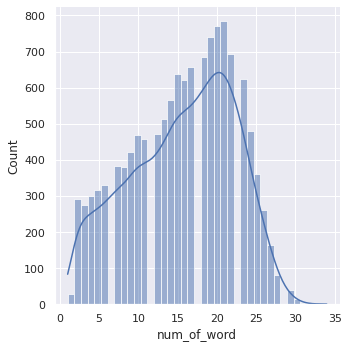

In [ ]:
sns.set_theme()
sns.displot(data=df_train,x='num_of_word',kde=True);

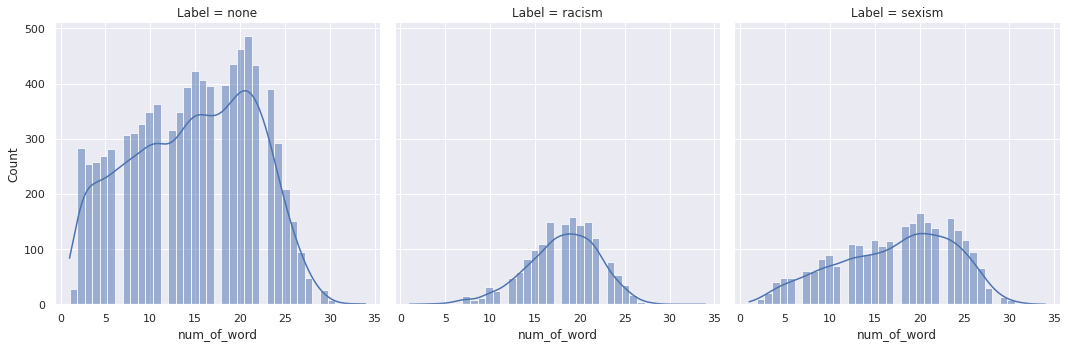

In [ ]:
sns.displot(data=df_train,x='num_of_word',col='Label',kde=True);

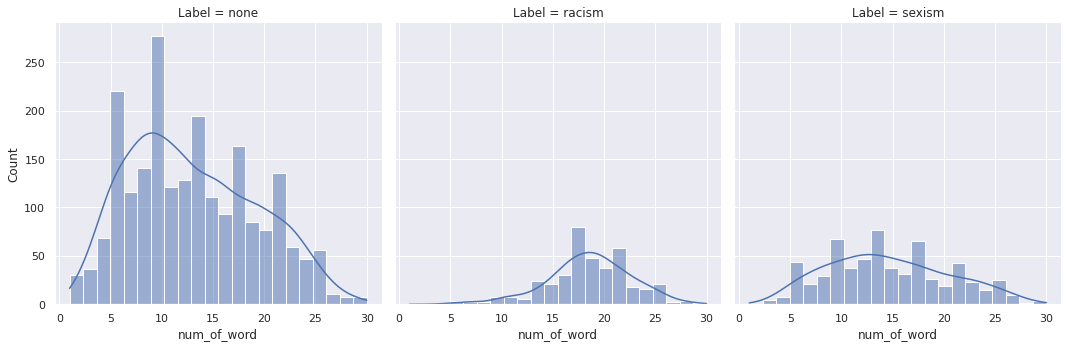

In [ ]:
sns.displot(data=df_test, x='num_of_word', col='Label',kde=True);

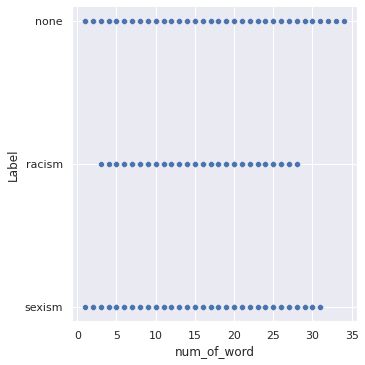

In [ ]:
sns.relplot(data=df_train,x="num_of_word", y="Label");

In [ ]:
#preprocessing
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_preprocessing(s):
  #lower text
  s = s.lower()
  # Change 't to 'not'
  s = re.sub(r"\'t", " not", s)
  # Change ':P to ''
  s = re.sub(r"\ :P", "", s)
  # Change '&gt to ''
  s = re.sub(r"\ &gt", "", s)
  #remove link
  s = re.sub(r'http\S+','',s)
  # Remove @name
  s = re.sub(r'(@.*?)[\s]', ' ', s)
  # Isolate and remove punctuations except '?'
  s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,\^\*])', r' \1 ', s)
  s = re.sub(r'[^\w\s\?]', ' ', s)
  # Remove some special characters
  s = re.sub(r'([\;\:\|•«\n])', ' ', s)
  # Remove stopwords except 'not' and 'can'
  s = " ".join([word for word in s.split() if word not in stopwords.words('english') or word in ['not', 'can']])
  # Remove trailing whitespace
  s = re.sub(r'\s+', ' ', s).strip()

  return s

In [ ]:
train = df_train
test = df_test

In [ ]:
train['Tweets'] = train['Tweets'].apply(text_preprocessing)
test['Tweets'] = test['Tweets'].apply(text_preprocessing) 

In [ ]:
#encode label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['Label'] = le.fit_transform(train['Label'])
train.head()

,id,Tweets,Label,num_of_word
0,7281,jokes puns flying free camping episode mkr mkr...,0,13
1,7282,mkr lets see producers think going better tv k...,0,19
2,7283,praying jac shaz well faves mkr,0,10
3,7284,rt pete evans paleo capitalist cookbook pulled...,0,14
4,7285,kat andre stay tonight stop watching kitchen r...,0,14


In [ ]:
le.classes_

array(['none', 'racism', 'sexism'], dtype=object)

In [ ]:
#encode label test set
from sklearn.preprocessing import LabelEncoder
test['Label'] = le.transform(test['Label'])
test.head()

,id,Tweets,Label,num_of_word
0,5014,mkr least judging honestly,0,7
1,5015,end steve going run away mexico go witness pro...,0,19
2,5016,catching mkr nikki amp katie get script say th...,0,28
3,5017,anyone made twitter account rob hat yet ? mkr,0,11
4,5020,someone pls assist colin washing hair sorry co...,0,21


In [ ]:
X_tr = train.Tweets.values
y_tr = train.Label
X_test = test.Tweets.values
y_test = test.Label

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train , X_val , y_train, y_Val = train_test_split(X_tr, y_tr, test_size = 0.1, random_state = 10)

In [ ]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_Val))

11546 11546
1283 1283


In [ ]:
#vectorize word with TFidf
from sklearn.feature_extraction.text import CountVectorizer
#calculate TF-IDF
X_train = np.array(X_train)
X_val = np.array(X_val)
cv = CountVectorizer(ngram_range = (1, 3), stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_val_cv = cv.transform(X_val)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
#tuning hyper parameter using grid search
def tuning_param(grid, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=10)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_macro',error_score=0)
  grid_result = grid_search.fit(X_train_cv, y_train)
  #best results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
%%time
#Model 1 : MultinomialNB 
from sklearn.naive_bayes import MultinomialNB
alpha = np.arange(1,10,0.1)
grid = dict(alpha = alpha)
model = MultinomialNB()
tuning_param(grid=grid, model = model)

Best: 0.760787 using {'alpha': 1.6000000000000005}
CPU times: user 3.09 s, sys: 285 ms, total: 3.37 s
Wall time: 27 s


In [ ]:
#create model
nb_model = MultinomialNB(alpha = 1.6)
nb_model.fit(X_train_cv, y_train)

MultinomialNB(alpha=1.6, class_prior=None, fit_prior=True)

In [ ]:
#score model
nb_model.score(X_val_cv, y_Val)

0.8074824629773967

In [ ]:
#transform X_test 
X_test_cv = cv.transform(X_test)

In [ ]:
#predict base on trained model
y_test_pred = nb_model.predict(X_test_cv)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['none', 'racism', 'sexism']
#print classification report
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

        none       0.73      0.99      0.84      2186
      racism       1.00      0.41      0.59       387
      sexism       0.77      0.09      0.16       633

    accuracy                           0.74      3206
   macro avg       0.83      0.50      0.53      3206
weighted avg       0.77      0.74      0.68      3206



In [ ]:
%%time
#model 2 : LogisticRegression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
C_value = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver = solver, penalty = penalty, C= C_value)
tuning_param(grid = grid, model = model)

Best: 0.760364 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
CPU times: user 2.38 s, sys: 151 ms, total: 2.53 s
Wall time: 6min 42s


In [ ]:
#create model 2
LG_model = LogisticRegression(C=10, solver='liblinear',penalty='l1')
LG_model.fit(X_train_cv,y_train)
LG_model.score(X_val_cv,y_Val)

0.8269680436477007

In [ ]:
y_pred_LG = LG_model.predict(X_test_cv)
print(classification_report(y_test, y_pred_LG, target_names=target_names))

              precision    recall  f1-score   support

        none       0.80      0.95      0.86      2186
      racism       1.00      0.66      0.80       387
      sexism       0.64      0.36      0.46       633

    accuracy                           0.79      3206
   macro avg       0.81      0.65      0.71      3206
weighted avg       0.79      0.79      0.78      3206



In [ ]:
%%time
#model 3 : SVM
from sklearn.svm import SVC
model = SVC()
kernel = ['poly', 'rbf','sigmoid']
C = [50,10,1.0,0.1,0.01]
gamma = ['scale']
grid= dict(kernel = kernel, C = C, gamma = gamma)
tuning_param(grid = grid , model = model)

In [ ]:
#create model 3
SVM_model = SVC(kernel = 'sigmoid', C= 1.0, gamma ='scale')
SVM_model.fit(X_train_cv,y_train)
SVM_model.score(X_val_cv,y_Val)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['none', 'racism', 'sexism']
y_pred_SVM = SVM_model.predict(X_test_cv)
print(classification_report(y_test, y_pred_SVM, target_names=target_names))

In [ ]:
%%time 
#model 4 : Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
n_estimators = [10, 50, 100, 200]
max_features = ['sqrt', 'log2']
grid = dict(n_estimators = n_estimators, max_features = max_features)
tuning_param(grid = grid , model = model)

Best: 0.675293 using {'max_features': 'sqrt', 'n_estimators': 200}
CPU times: user 1min 50s, sys: 141 ms, total: 1min 50s
Wall time: 2h 58min 56s


In [ ]:
#create model 4
RF_model = RandomForestClassifier(n_estimators = 200, max_features = 'sqrt')
RF_model.fit(X_train_cv,y_train)
RF_model.score(X_val_cv,y_Val)

0.7957911145752143

In [ ]:
y_pred_RF = RF_model.predict(X_test_cv)
print(classification_report(y_test, y_pred_RF, target_names=target_names))

              precision    recall  f1-score   support

        none       0.73      0.99      0.84      2186
      racism       1.00      0.33      0.50       387
      sexism       0.76      0.12      0.21       633

    accuracy                           0.74      3206
   macro avg       0.83      0.48      0.52      3206
weighted avg       0.77      0.74      0.67      3206



In [ ]:
%%time
#model 5 : XGBoost

from xgboost import XGBClassifier
model = XGBClassifier()
colsample_bytree = [0.3, 0.7]
max_depth = [ 3, 5, 7, 10]
n_estimators = [ 50, 100, 200]
grid = dict(colsample_bytree = colsample_bytree, max_depth = max_depth, n_estimators = n_estimators)
tuning_param(grid = grid, model = model)

Best: 0.763925 using {'colsample_bytree': 0.3, 'max_depth': 10, 'n_estimators': 200}
CPU times: user 1min 20s, sys: 456 ms, total: 1min 20s
Wall time: 4h 51min 34s


In [ ]:
#create model 5
XGB_model = XGBClassifier(colsample_bytree= 0.3, max_depth= 10, n_estimators=200 )
XGB_model.fit(X_train_cv,y_train)
XGB_model.score(X_val_cv,y_Val)

0.8199532346063912

In [ ]:
from sklearn.metrics import classification_report
target_names = ['none', 'racism', 'sexism']
#print classification report
y_pred_XGB = XGB_model.predict(X_test_cv)
print(classification_report(y_test, y_pred_XGB, target_names=target_names))

              precision    recall  f1-score   support

        none       0.76      0.98      0.86      2186
      racism       1.00      0.65      0.78       387
      sexism       0.69      0.16      0.26       633

    accuracy                           0.78      3206
   macro avg       0.82      0.60      0.63      3206
weighted avg       0.78      0.78      0.73      3206

